In [1]:
## path to datasets
datadir='../Datasets/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf

In [3]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'MRP/Cit_Phy.csv', names = ['from', 'to'], header=1)
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True)
print(g.vcount(),'nodes and',g.ecount(),'directed edges')
D.head()

27770 nodes and 352806 directed edges


from       to
0  1001  9308122
1  1001  9309097
2  1001  9311042
3  1001  9401139
4  1001  9404151

In [4]:
g.is_connected()

False

In [5]:
# number of weak connections
n = 0
weak_clus = {}
cl = g.clusters(mode='WEAK').membership
for i in range(g.vcount()):
    if cl[i]>0:
        weak_clus['id'] = i
        weak_clus['rel'] = g.vs[i]
        n += 1
print(n)        

370


In [6]:
g.maxdegree()

2468

In [7]:
g.vs.select(_degree=g.maxdegree())["name"]

[9711200]

In [8]:
max(g.coreness())

37

In [9]:
g.is_simple()

False

In [10]:
ig.summary(g)

IGRAPH DN-- 27770 352806 -- 
+ attr: name (v)


In [11]:
loo = g.is_loop()
n = 0
m = 0
for i in loo:
    n +=1
    if i == True:
        m +=1
#print(n)      
print("Number of loops:", m)    

Number of loops: 39


In [12]:
g.vs(name = 9711200)

IGRAPH DN-- 87 465 -- 
+ attr: name (v)
None


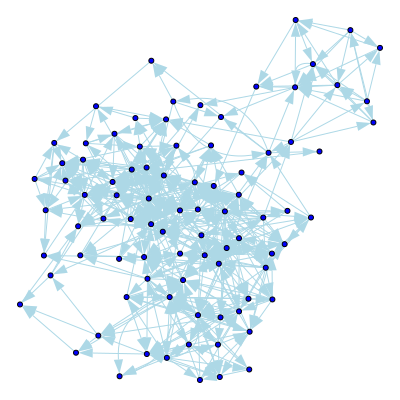

In [13]:

#g.vs["label"] = g.vs["name"]
g = g.simplify()
#btwn = g.betweenness()
btwn = g.degree()
ntile = np.percentile(btwn, 98)
pruned_vs = g.vs.select([v for v, b in enumerate(btwn) if b >= ntile])
pruned_graph = g.subgraph(pruned_vs).clusters().giant()
print(ig.summary(pruned_graph))

ig.plot(pruned_graph,  vertex_size=5,
        vertex_color='blue',
        #vertex_label=['first', 'second', 'third', 'fourth'],
        edge_width=1,
        edge_color= 'light blue',
       bbox=(0,0,400,400))



IGRAPH DN-- 250 1586 -- 
+ attr: name (v)
None


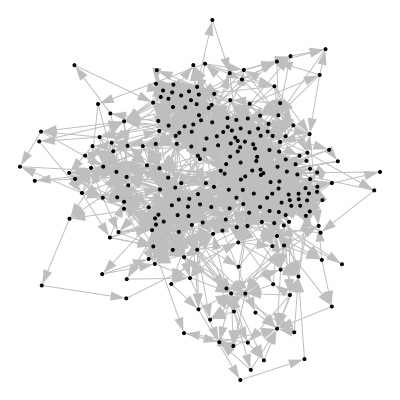

In [14]:
#g.vs["label"] = g.vs["name"]
g = g.simplify()
btwn = g.betweenness()
#btwn = g.degree()
ntile = np.percentile(btwn, 99)
pruned_vs = g.vs.select([v for v, b in enumerate(btwn) if b >= ntile])
pruned_graph = g.subgraph(pruned_vs).clusters().giant()
print(ig.summary(pruned_graph))

ig.plot(pruned_graph,  vertex_size=3,
        vertex_color='black',
        #vertex_label=['first', 'second', 'third', 'fourth'],
        edge_width=1,
        edge_color= 'grey',
       bbox=(0,0,400,400))

IGRAPH DN-- 32 104 -- 
+ attr: label (v), name (v)
None


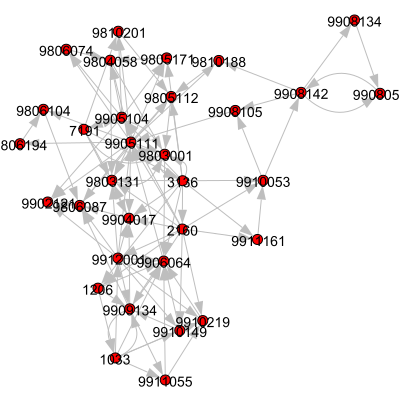

In [15]:
g.vs["label"] = g.vs["name"]
g = g.simplify()
#btwn = g.betweenness()
btwn = g.degree()
ntile = np.percentile(btwn, 99)
pruned_vs = g.vs.select([v for v, b in enumerate(btwn) if b >= ntile])
pruned_graph = g.subgraph(pruned_vs).clusters().giant()
print(ig.summary(pruned_graph))

ig.plot(pruned_graph,  vertex_size=10,
        vertex_color='red',
        #vertex_label=['first', 'second', 'third', 'fourth'],
        edge_width=1,
        edge_color= 'grey',
       bbox=(0,0,400,400))

In [16]:
## compute and store basic stats in a table

def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
            np.max(deg),G.diameter(),np.max(G.clusters(mode='strong').membership), np.max(G.clusters(mode='weak').membership), G.clusters().giant().vcount(),
            sum([x==0 for x in G.degree()]),G.transitivity_undirected(mode='nan'),
            G.transitivity_avglocal_undirected(mode='nan')]
S = []
S.append(['citations'] + baseStats(g))
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','strong components','weak components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$']).transpose()
D

0
graph              citations
nodes                  27770
edges                 352767
$d_{min}$                  0
$d_{mean}$         25.406338
$d_{median}$            14.0
$d_{quant_{99}}$      166.31
$d_{max}$               2468
diameter                  37
strong components      20085
weak components          142
largest                 7464
isolates                   1
$C_{glob}$          0.119569
$C_{loc}$            0.32961

In [21]:
sg = g.clusters().giant()
print(g.get_diameter())
print(sg.get_diameter())


[8396, 7394, 5251, 5249, 5248, 1292, 1585, 1148, 1208, 516, 7093, 2605, 1467, 2574, 2669, 2549, 811, 844, 5044, 5065, 17289, 17286, 18682, 18688, 18921, 18922, 17644, 21600, 19822, 19817, 19819, 19831, 18505, 18375, 17541, 11887, 11888, 11894]
[3257, 2959, 2262, 2261, 2260, 539, 693, 451, 494, 60, 2903, 1107, 632, 1099, 1147, 1089, 266, 291, 2157, 2175, 6256, 6253, 6794, 6800, 6884, 6885, 6426, 7420, 7164, 7159, 7161, 7173, 6756, 6699, 6370, 4263]


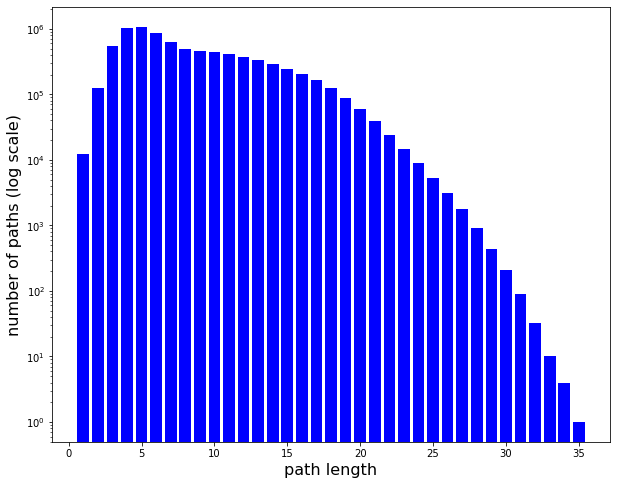

In [28]:
## shortest paths length from a given node
from collections import Counter
#np.random.seed(50)
#sg = g.clusters().giant()
#V = sg.vcount()
V = np.random.choice(g.vcount(),size=1000,replace=False) ## sample
sp = []
for v in V:
    sp.extend(g.shortest_paths(source=v)[0])

c = Counter(sp)
s = sorted(c.items())

fig, ax = plt.subplots(figsize=(10,8))
x=[]
y=[]
for i in s:
    if i[0]>0:
        x.append(i[0])
        y.append(i[1])
b = ax.bar(x, y, color='blue') 

ax.set_yscale('log')
ax.set_xlabel('path length',fontsize=16)
ax.set_ylabel('number of paths (log scale)',fontsize=16);
#plt.title("shortest path lengths from random nodes", fontsize=20)
plt.show()


In [29]:
g.vs['size'] = 3
g.es['color'] = 'grey'
g.vs['color'] = 'black'

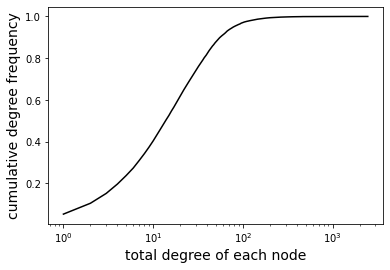

In [30]:
## degree distribution 

deg = g.degree()
e = ecdf(deg)
x = np.arange(1,max(deg),1)
y = [e(i) for i in x]
plt.semilogx(x,y,color='black',label='Citations')
plt.xlabel('total degree of each node',fontsize=14)
plt.ylabel('cumulative degree frequency',fontsize=14);
plt.show()

In [36]:
## plot subgraph
DAT = pd.read_csv(datadir+'MRP/Cit_Phy.csv', names = ['from', 'to'], header=1)
g1 = ig.Graph.TupleList([tuple(x) for x in DAT.values], directed=True)

g1 = g1.simplify()
#sg = g.clusters().giant()
ly = g1.layout_auto()
g1.vs['x'] = [x[0] for x in ly]
g1.vs['y'] = [x[1] for x in ly]
g1.vs['size'] = 3
g1.es['color'] = 'grey'
g1.vs['color'] = 'red'

In [37]:
g1.is_simple()

True

In [45]:
#Visualizing the subgraph
z = 155 ## adjust to zoom in or out
V = [v for v in g1.vs() if v['x']<z and v['x']>-z and v['y']<z and v['y']>-z]

ssg = g1.subgraph(V).clusters().giant()
ssg.vs['size'] = 5
print(ssg.vcount())

ig.plot(ssg,bbox=(0,0,400,400))

759
